# WD in python with fortran

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import display, Math
from os import listdir

from multiprocessing import Pool
from multiprocessing import cpu_count
import emcee
import subprocess
import re
import statistics
import corner
import pandas as pd

from astropy.timeseries import LombScargle
from chainconsumer import ChainConsumer

from brokenaxes import brokenaxes
import matplotlib.patheffects as path_effects

import re
import numpy as np
import subprocess
from pathlib import Path

import numpy as np
import statistics
import corner
from matplotlib.ticker import FormatStrFormatter



* Some useful constants

In [30]:
c = 299792458;            #[m/s]
UA = 149597870700;        #[m] #According https://aas.org/posts/story/2013/08/report-2012-iau-xxviii-general-assembly
pi = np.pi;

#According https://www.iau.org/static/resolutions/IAU2015_English.pdf 
G = 6.67408*10**(-11);    # 2014 CODATA 6.67408 (±0.00031)×10−11m3kg−1s−2
G_gauss = (2*pi)**2       # [year, AU, M_Sun] 
R_Sun = 6.957*10**(8);    #[m]
L_Sun = 3.827*10**(26)    #[W]
M_Sun = 1.9891*10**(30);  #[Kg]
R_Ear = 6.3781*10**(6);   #[m]
R_Jup = 7.1492*10**(7);   #[m]
M_Jup = 1.89813*10**(27); #[Kg]
T_Sun = 5778;

* Reading the data

In [31]:
obj = 'TIC74386000'
sec = ['Setor 43', 'Setor 44', 'Setor 45']

#=======================================================
def is_dat_file(file_path: str) -> bool:
    return file_path.lower().endswith('.txt')

files = listdir('.')

filter_dat_files = filter(is_dat_file, files)

dat_files = sorted(list(filter_dat_files))

list_dat = []
for c in range (len(dat_files)):
    list_dat.append(np.loadtxt('{}'.format(dat_files[c])))
#=======================================================

x0, y0, ey0 = np.loadtxt('lc_{}.dat'.format(obj), unpack=True)
x0 = x0[:10050]
y0 = y0[:10050]
ey0 = ey0[:10050]

x_rv1, y_rv1, ey_rv1 = np.loadtxt('rv1', unpack=True)
x_rv2, y_rv2, ey_rv2 = np.loadtxt('rv2', unpack=True)

stars = []

print(x0.shape)
print(x_rv1.shape)

(10050,)
(12,)


- Define initial values for MCMC

In [32]:
# data for tic74386000
lcout = "lcout.active"
mode = 2

p = 33.62089659
ep = 2490.00686273
T1t = 2.5 #2.5119
T1t_err1 = 200
T1t_err2 = 200
phaset = -0.0672620

ft = 1

alb1 = 0.5
alb2 = 0.5
hl = 1.0
cl = 1.0
zt = 0
ext = 0

flux0 = 1.00

ecct = 0.268#968
perrt = 2.630702 #2.61799388 147.82=2.57995
vgat = 12.34
F1 = F2 = np.sqrt((1+ecct)/(1/ecct)**3)

dpct = 0.00
dperrt = 0.00

#parametros a serem variados

a0 = 118.0272336 #139.3393744
q0 = 0.7642590 #0.7823110
i0 = 87.1322270
pot10 = 25.8719721
pot20 = 19.7953092
T20 = 3.2069130

f0 = -4.950520

soln = np.array([])
soln = a0, q0, i0, pot10, pot20, T20, f0
print(soln)

(118.0272336, 0.764259, 87.132227, 25.8719721, 19.7953092, 3.206913, -4.95052)


In [33]:
# =====================================================================
# 1 Calcular fase e ordenar
# =====================================================================
phase0 = ((x0 - ep) / p) % 1  # fase entre 0 e 1
aux = pd.DataFrame({'phase': phase0, 'y': y0, 'ey': ey0}).sort_values('phase').to_numpy()
phasex = np.linspace(-1, 2, num=1000)
# =====================================================================

# Primeiro, você cria um "template" global com todos os valores fixos
header_template = {
    "ep": ep,
    "p": p,
    "phaset": phaset,
    "mode": mode,
    "perrt": perrt,
    "dperrt": dperrt,
    "ecct": ecct,
    "F1": F1,
    "F2": F2,
    "vgat": vgat,
    "T1t": T1t,
    "alb1": alb1,
    "alb2": alb2,
    "dpct": dpct,
    "hl": hl,
    "cl": cl,
    "zt": zt,
    "flux0": flux0,
    "ext": ext,
    "at": a0,
    "qt": q0,
    "it": i0,
    "pot1t": pot10,
    "pot2t": pot20,
    "T2t": T20
}

# ---------------------------
# Util: encontrar bloco no arquivo
# ---------------------------
def find_block(file_path, start_regex, offset=0):
    """
    Retorna (start_line_index, n_rows) onde o bloco começa e quantas linhas (até linha em branco).
    start_regex: regex (string) para localizar a linha de início; offset adiciona (p.ex. +1, +2).
    """
    start_re = re.compile(start_regex)
    blank_re = re.compile(r'^\s*$')

    start = None
    n_rows = 0
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if start is None and start_re.search(line):
                start = i + offset
                continue
            if start is not None and blank_re.match(line):
                n_rows = i - start
                break
    if start is None:
        return 0, 0
    return start, n_rows

# ---------------------------
# Util: escrevendo lcin.active
# ---------------------------
def write_lcin(output_path="lcin.active", mpage=1, phaset_multiplier=1.0, header_values=header_template):
    """
    Cria o arquivo lcin.active com os blocos formatados. 
    header_values: dict opcional para sobrescrever variáveis usadas nos templates.
    phaset_multiplier: multiplica `phaset` (usado para execução RVs).
    """
    # Você deve fornecer (por variáveis globais ou via header_values) todas as variáveis usadas abaixo.
    # Usamos .get do dict para permitir sobrescritas; caso não exista, assumimos nomes globais.
    hv = header_values or {}

    # helper para pegar variável de hv ou do escopo global
    def H(name):
        return hv.get(name, globals().get(name))

    lines = []
    lines.append('{:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:1d} {:2d} {:2d} {:1d} {:1d} {:1d} {:1d} {:6d}'.format(
        mpage, 2, 1, 0, 0, 1, 1, 0, -3, -3, 1, 1, 1, 0, 0))

    lines.append('{:1d}{:15.6f}{:17.10f}{:14.6f}{:10.4f}{:8.5f}{:3d}{:11.4f}{:2d}{:11.0f}'.format(
        2, H('ep'), H('p'), 0.0000, H('phaset') * phaset_multiplier, 0.0000, 1, 0, 2, 138472375))

    lines.append('{:14.6f}{:15.6f}{:13.6f}{:12.6f}{:12.6f}{:12.6f}{:12.6f}{:10.4f}{:2d}{:8.4f}'.format(
        55369.000014, 55369.018041, 0.00000, -0.250000, 0.750000, 0.000001, 0.250000, 0.7500, 1, 0.6640))

    lines.append('{:2d}{:2d}{:2d}{:2d}{:4d}{:4d}{:13.6f}{:14.6f}{:8.5f}{:8.2f}'.format(
        H('mode'), 0, 1, 1, 30, 30, H('perrt'), H('dperrt'), 0.00000, 1.00))

    lines.append('{:6.5f}{:12.6f}{:10.4f}{:10.4f}{:10.4f}{:9.3f}{:7.3f}{:7.3f}{:7.2f}{:10.4f}{:10.4f}'.format(
        H('ecct'), H('at'), H('F1'), H('F2'), H('vgat'), H('it'), 1.00, 1.00, -0.50, 1.0000, 1.0000))

    lines.append('{:7.4f} {:7.4f}{:7.3f}{:7.3f}{:13.6f}{:13.6f}{:13.6f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:8.5f}'.format(
        H('T1t'), H('T2t'), H('alb1'), H('alb2'), H('pot1t'), H('pot2t'), H('qt'), 0.500, 0.600, 0.172, 0.163, H('dpct')))

    lines.append('{:12.6f}{:14.7f}{:11.5f}{:9.6f}{:10.7f}{:17.8f}'.format(0.0, 0.0, 0.0, 0.0, 0.0, 0.0))

    lines.append('{:3d}{:13.7f}{:13.7f}{:7.3f}{:7.3f}{:7.3f}{:7.3f}{:12.4f}{:11.4f}{:8.3f}{:8.4f}{:10.6f}{:8.4f}{:12.5f}'.format(
        95, H('hl'), H('cl'), 0.260, 0.225, -0.827, -0.723, 0.00000, 0.0000, H('zt'), H('flux0'), 0.55000, H('ext'), 0.378))

    lines.append('{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(
        300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000))

    lines.append('{:9.5f}{:9.5f}{:9.5f}{:9.5f}{:14.5f}{:14.5f}{:14.5f}{:14.5f}'.format(
        300.000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000))

    lines.append('{:3.0f}.'.format(150.))
    lines.append('{:1.0f} '.format(9))

    # Write file
    with open(output_path, 'w') as fo:
        fo.write("\n".join(lines) + "\n")


Bin T of the 1000 to 97


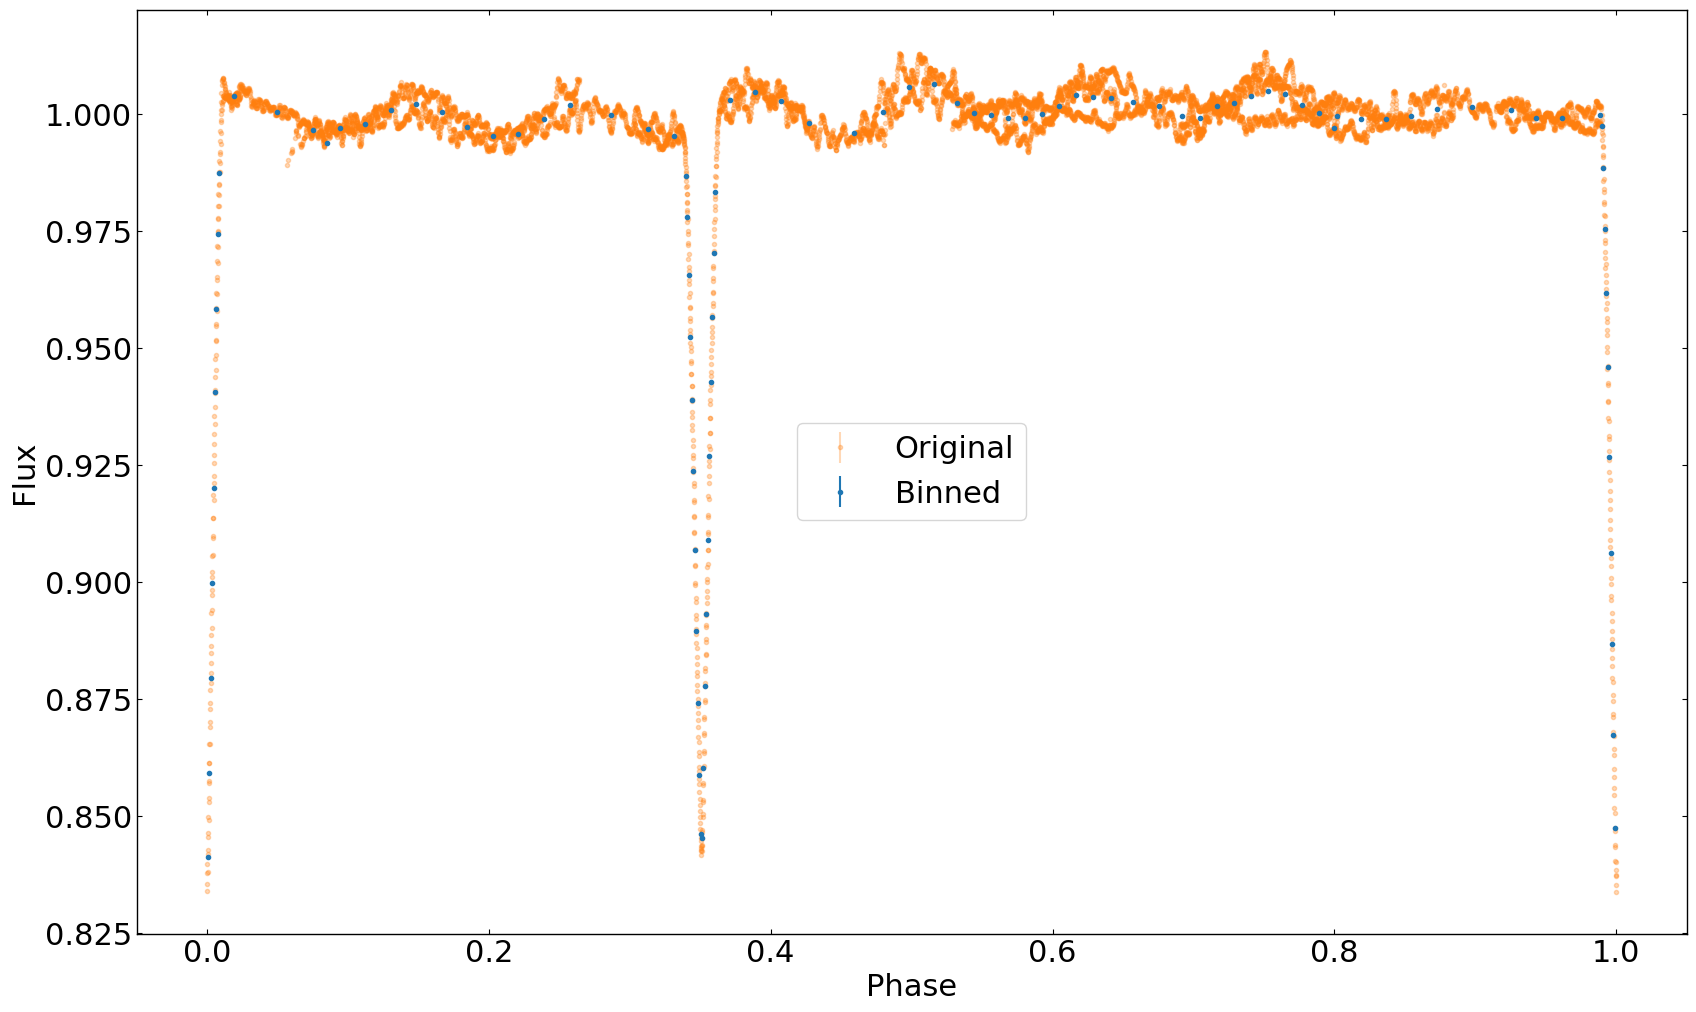

In [34]:
# ============================
# Parâmetros (edite aqui)
# ============================
# ep, p, obj, x0, y0, ey0 devem estar definidos previamente
# ---------------------------------------------------------------------

# Bins (intervalos de agrupamento)
N_out  = 175  # número de pontos por bin dentro dos eclipses
N_in = 10    # número de pontos por bin fora dos eclipses

# Intervalos de eclipse: [(min1, max1), (min2, max2), ...]
# — você pode ajustar livremente estes valores —
eclipse_intervals = [(0.01, 0.34), (0.36, 0.9875)]

# Limite inferior de fluxo para considerar eclipse
flux_threshold = 0.9915

# =====================================================================
# 1 Criar máscara para eclipses
# =====================================================================
# Combinar os intervalos definidos
interval_mask = np.zeros(len(aux), dtype=bool)
for a, b in eclipse_intervals:
    interval_mask |= (aux[:, 0] > a) & (aux[:, 0] < b)

# Combinar com o limite de fluxo
mask_outside = (aux[:, 1] > flux_threshold) & interval_mask
mask_eclipse = ~mask_outside

aux1 = aux[mask_outside]  # fora dos eclipses
aux2 = aux[mask_eclipse]  # eclipses

# =====================================================================
# 2 Função para binarizar dados
# =====================================================================
def bin_data(data, N):
    if len(data) < N:
        return data[:, 0], data[:, 1], data[:, 2]
    n_bins = len(data) // N
    data = data[:n_bins * N].reshape(n_bins, N, 3)
    return data.mean(axis=1).T  # retorna 3 arrays: phase, y, ey

# =====================================================================
# 3 Aplicar binning
# =====================================================================
phase_out,  y_out,  ey_out  = bin_data(aux1, N_out)
phase_in, y_in, ey_in = bin_data(aux2, N_in)

# Concatenar e ordenar tudo por fase
phase = np.concatenate([phase_out, phase_in])
y     = np.concatenate([y_out, y_in])
ey    = np.concatenate([ey_out, ey_in])

order = np.argsort(phase)
phase, y, ey = phase[order], y[order], ey[order]

# =====================================================================
# 4 Resultados e gráfico
# =====================================================================
print(f'Bin T of the {len(phasex)} to {len(phase)}')

plt.figure(figsize=(20, 12))
plt.errorbar(phase0, y0, yerr=0, fmt="C1.", alpha=0.3, label="Original")
plt.errorbar(phase, y, yerr=ey, fmt="C0.", label="Binned")

plt.xlabel("Phase")
plt.ylabel("Flux")
plt.legend()
#plt.savefig(f"lcbin_{obj}.pdf", bbox_inches="tight")
plt.show()


In [35]:
# ---------------------------
# Função de log-likelihood (otimizada)
# ---------------------------
def log_likelihood(theta, phase, y, ey):
    at, qt, it, pot1t, pot2t, T2t, f = theta

    # Sobrescreve só os parâmetros variáveis
    header_values = header_template.copy()
    header_values.update({
        "at": at,
        "qt": qt,
        "it": it,
        "pot1t": pot1t,
        "pot2t": pot2t,
        "T2t": T2t
    })

    # 1) executar modelo fotométrico (phaset multiplicador 1x)
    # grava fases (hjd.dat) - substituir por Path / atomic write se desejar
    np.savetxt('hjd.dat', phase)
    write_lcin(header_values=header_values)
    subprocess.run(["./lc.e"], check=True)

    linicio, lfim = find_block(lcout, r'\s*JD\s+Phase', offset=1)
    if lfim <= 0:
        raise RuntimeError("Não encontrou bloco photometry em lcout.active")
    model = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(5,))
    sigma = ey ** 2 + (model ** 2) * np.exp(2 * f)
    chi = -0.5 * np.sum((y - model) ** 2 / sigma + np.log(sigma))

    # 2) ler tabela 'stars' (opcional)
    linicio2, lfim2 = find_block(lcout, r'\s*Star\s+M/Msun', offset=0)
    if lfim2 > 0:
        stars.append(np.loadtxt(lcout, skiprows=linicio2, max_rows=lfim2, usecols=(0,1,2,3,4,5,6), dtype=str))

    # 3) RVs: rodar com phaset*2
    # grava hjd para rv1 (assumindo x_rv1 definido)
    np.savetxt('hjd.dat', x_rv1)
    write_lcin(mpage=2, phaset_multiplier=2.0, header_values=header_values)
    subprocess.run(["./lc.e"], check=True)

    linicio_rv, lfim_rv = find_block(lcout, r'\s*JD\s+Phase', offset=1)
    if lfim_rv <= 0:
        raise RuntimeError("Não encontrou bloco RV em lcout.active")
    # carrega coluna 6 e 7 (indexados a partir de 0) conforme seu código
    model_rv1 = np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(6,))
    sigma2_rv1 = ey_rv1 ** 2 + (model_rv1 ** 2) * np.exp(2 * f)
    chi_rv1 = -0.5 * np.sum((y_rv1 - model_rv1) ** 2 / sigma2_rv1 + np.log(sigma2_rv1))

    model_rv2 = np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(7,))
    sigma2_rv2 = ey_rv2 ** 2 + (model_rv2 ** 2) * np.exp(2 * f)
    chi_rv2 = -0.5 * np.sum((y_rv2 - model_rv2) ** 2 / sigma2_rv2 + np.log(sigma2_rv2))

    return chi * 0.50 + chi_rv1 * 0.25 + chi_rv2 * 0.25

# ---------------------------
# Priors / Probability inalterados (somente movidos)
# ---------------------------
def log_prior(theta):
    at, qt, it, pot1t, pot2t, T2t, f = theta
    if (a0-25) < at < (a0+25) and (q0-0.26) < qt < (q0+0.26) and (i0-0.5) < it < (i0+0.5) \
       and (pot10-9.00) < pot1t < (pot10+9.00) and (pot20-9.50) < pot2t < (pot20+9.50) \
       and (T20-0.45) < T2t < (T20+0.45) and -9.0 < f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, phase, y, ey):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, phase, y, ey)

# ---------------------------
# Criação de posições iniciais (vectorizada)
# ---------------------------
def make_initial_positions(soln):
    """
    Gera pos3 igual ao comportamento anterior: nwalkers = 2 * len(soln),
    cada walker com pequenas perturbações separadas por stds específicas.
    soln: array 1D (len = ndim)
    retorna pos3, nwalkers, ndim
    """
    ndim = len(soln)
    nwalkers = 2 * ndim
    # stds: standard deviations (desvios-padrão) - ajuste conforme necessário
    stds = np.array([50.00e-3, 0.52e-3, 1.00e-3, 18.00e-3, 19.00e-3, 0.90e-3, 10.0e-4])
    if len(stds) != ndim:
        raise ValueError("A dimensão de 'stds' deve ser igual a len(soln). Atualize os valores.")
    # gerar matriz (nwalkers, ndim)
    perturb = np.random.randn(nwalkers, ndim) * stds
    pos3 = soln.reshape(1, -1) + perturb
    return pos3, nwalkers, ndim

pos3, nwalkers, ndim = make_initial_positions(np.array(soln))


- Run the MCMC

In [36]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(phase, y, ey), threads=cpu_count())
sampler.run_mcmc(pos3, 1, progress=True)

samples = sampler.chain[:, :, :].reshape((-1, ndim))
#samples = sampler.get_chain(discard=0, thin=1, flat=True)
np.savetxt('samples.dat', samples, fmt='%s')

100%|██████████| 1/1 [00:33<00:00, 33.41s/it]


## Post-distribution

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

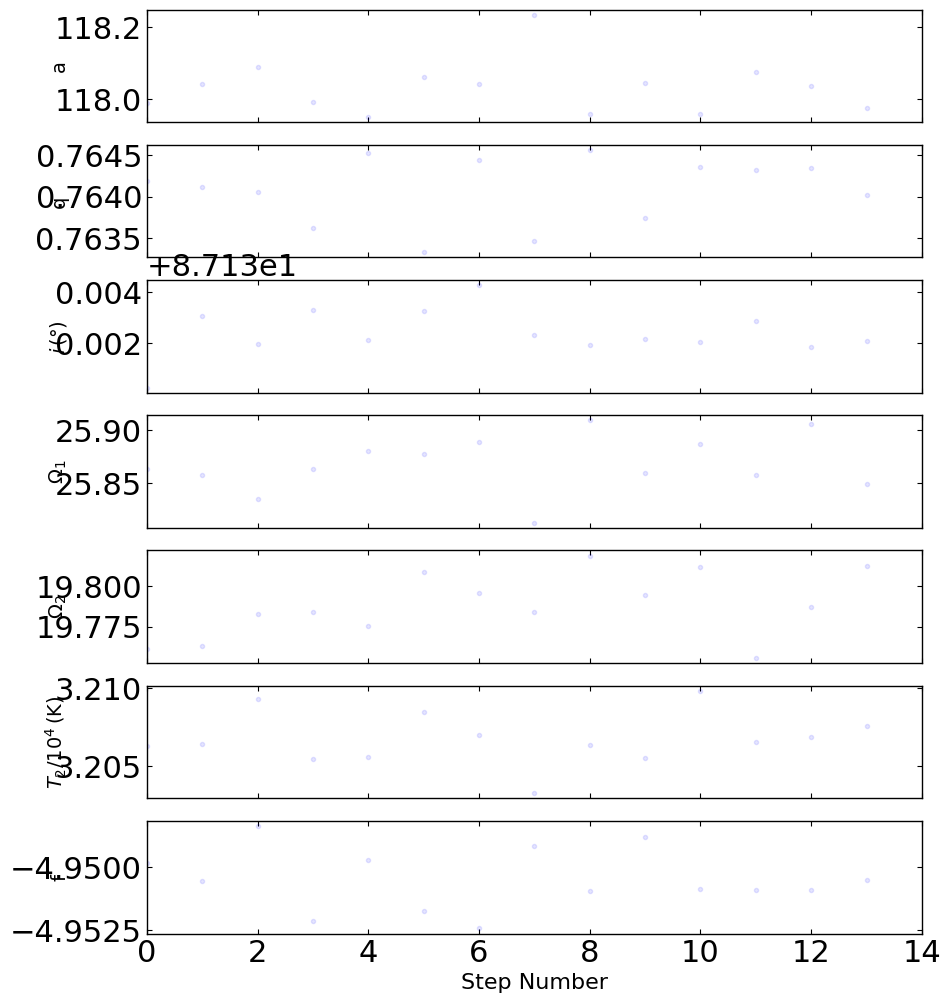

In [37]:
fig, axes = plt.subplots(ndim, figsize=(10, 12), sharex=True)

labels = ["a", "q", r"$i\,(\degree)$", r"$\Omega_1$", r"$\Omega_2$", r"$T_2/10^{4}\,\mathrm{(K)}$", "f"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i,], ".b", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], size=14)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step Number", size=16);
fig.savefig("1_steps_{}.jpg".format(obj), bbox_inches='tight', dpi=300)

bparam = []

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    
    txt = r"$\displaystyle {{ {0} }} = {1:.6f}_{{-{2:.4f}}}^{{+{3:.4f}}}$"
    txt = txt.format(
        labels[i],   # nome do parâmetro
        mcmc[1],     # valor mediano
        q[0],        # erro inferior
        q[1]         # erro superior
    )
    
    bparam.append([labels[i], mcmc[1], q[0], q[1]])
    display(Math(txt))


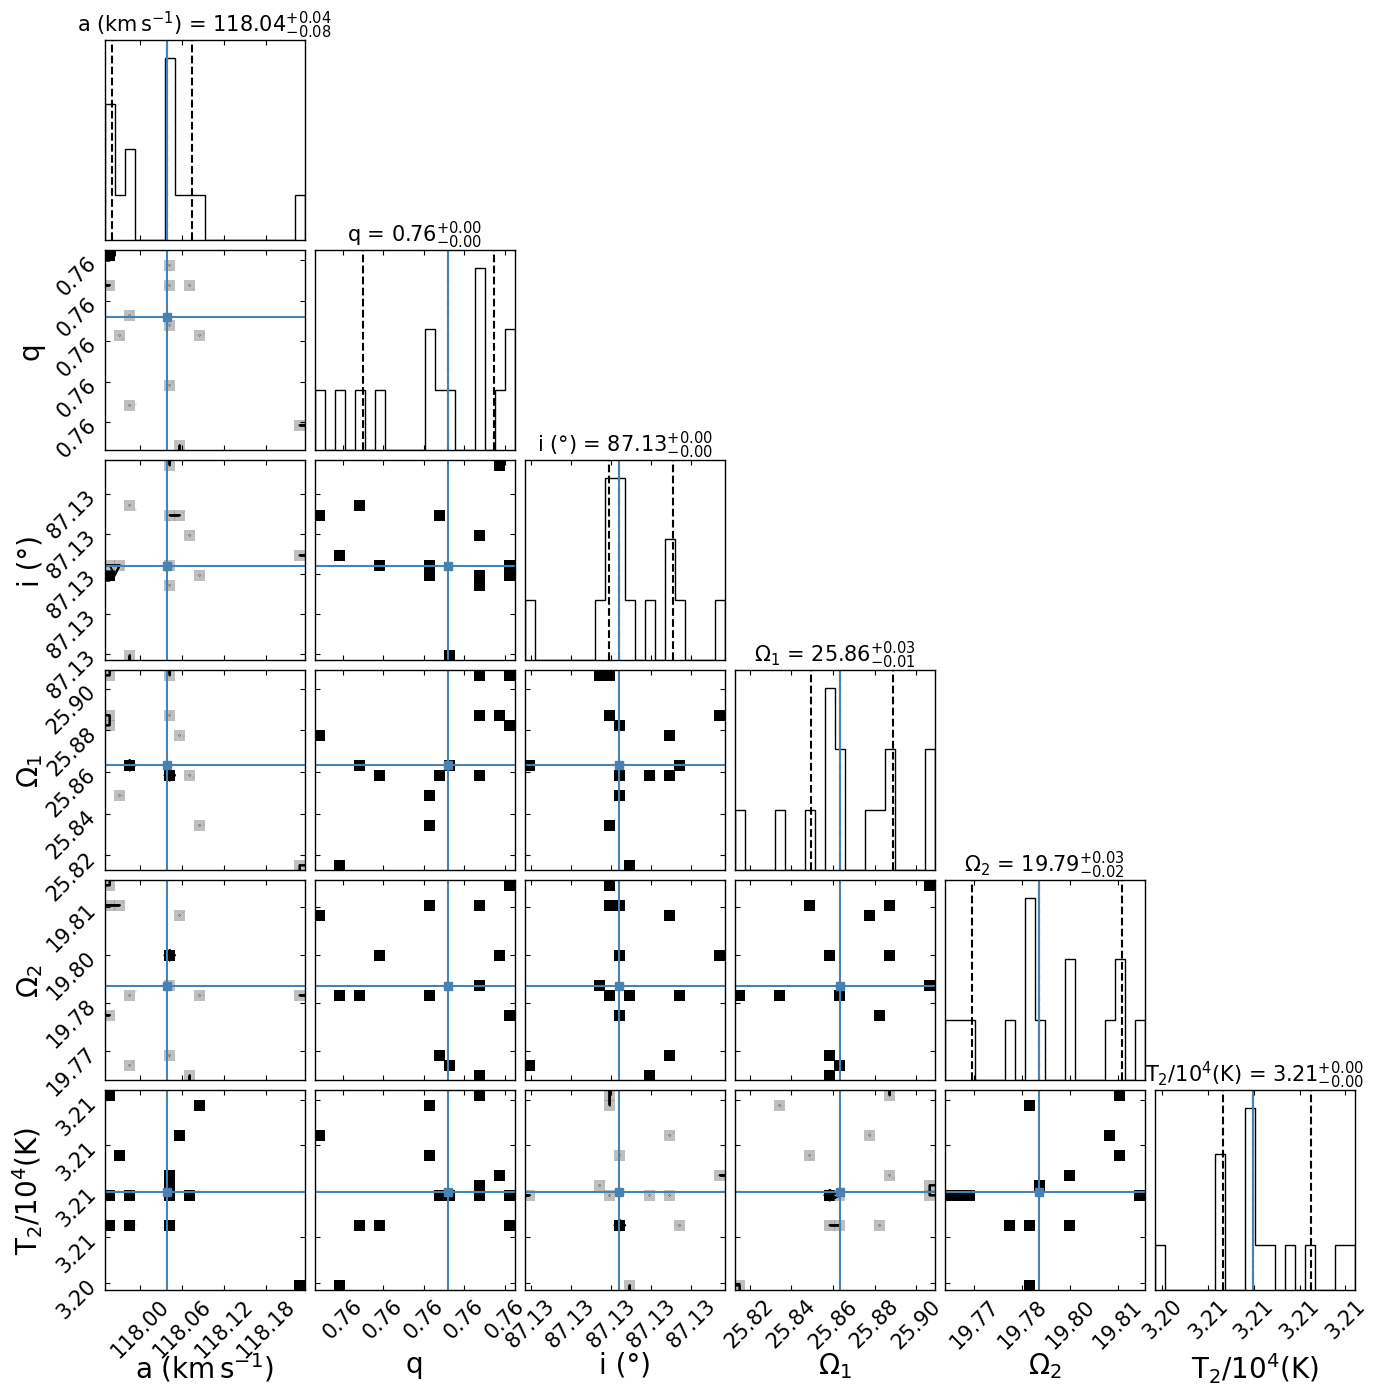

In [38]:
# Valores verdadeiros (truths) dos parâmetros
at, qt, it, pot1t, pot2t, T2t = [bparam[i][1] for i in range(6)]

# Labels para o corner plot
corner_labels = [
    "a (km$\,$s$^{-1}$)", "q", "i (°)",
    "$\Omega_1$", "$\Omega_2$", "T$_2/10^{4}$(K)"
]

# Criando o corner plot
fig = corner.corner(
    samples[:, :-1], 
    labels=corner_labels,
    title_fmt='.2f', 
    quantiles=(0.16, 0.5, 0.84),
    truths=[at, qt, it, pot1t, pot2t, T2t],
    show_titles=True,
    title_kwargs=dict(fontsize=15),
    label_kwargs=dict(fontsize=20)
)

# Extraindo os eixos
axes = np.array(fig.axes).reshape((ndim-1, ndim-1))

# Ajustando ticks e formatação
for yi in range(ndim-1):
    ax = axes[yi, 0]
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%4.2f'))

for xi in range(ndim-1):
    ax = axes[-1, xi]
    ax.tick_params(axis='x', labelsize=15)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%4.2f'))

# Salvando figura
fig.savefig("2_posteriori_{}.jpg".format(obj), bbox_inches='tight', dpi=300)
fig.savefig("2_posteriori_{}.pdf".format(obj), bbox_inches='tight', dpi=300)

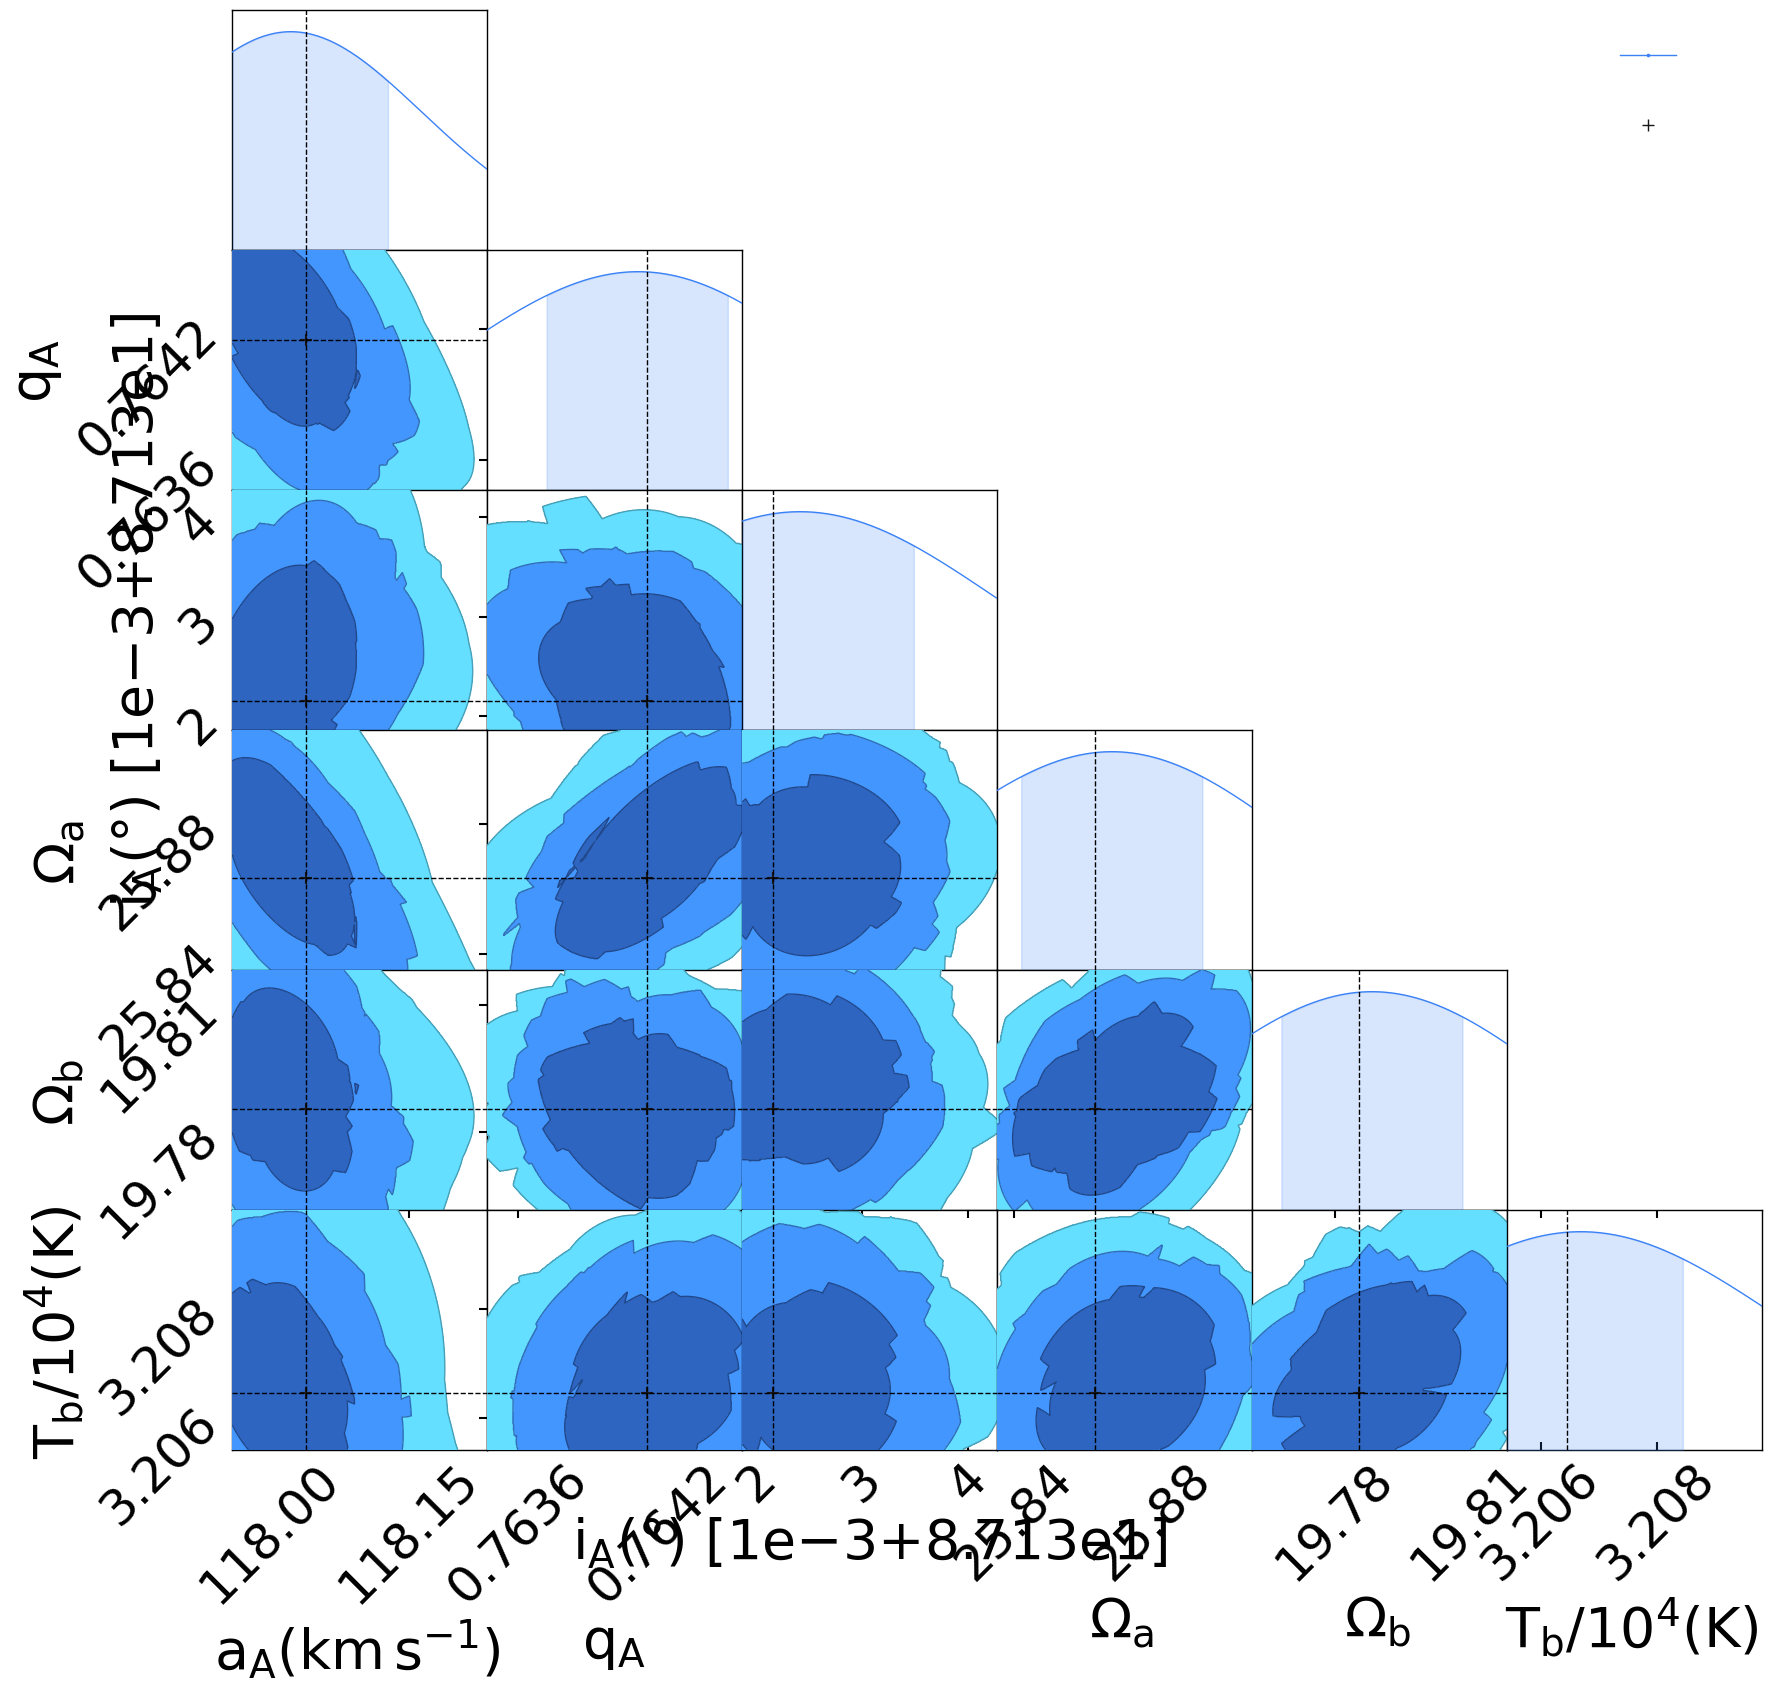

In [39]:
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

cd = pd.DataFrame({
    r"a$_{\rm A}$(km$\,$s$^{-1}$)": samples[:, 0],
    r"q$_{\rm A}$": samples[:, 1],
    r"i$_{\rm A}$(°)": samples[:, 2],
    r"$\Omega_{\rm a}$": samples[:, 3],
    r"$\Omega_{\rm b}$": samples[:, 4],
    r"T$_{\rm b}/10^{4}$(K)": samples[:, 5]
})

c = ChainConsumer()
c.add_chain(Chain(samples=cd,
                  name="",
                  color="blue",
                  plot_cloud=False,
                  plot_point=True,
                  #marker_style="*",
                  shade_alpha=1.0,
                  linewidth=1.0,
                  sigmas=np.linspace(0, 2, 4),
                  kde=1.5,
                  zorder=5
))
c.add_marker(location={r"a$_{\rm A}$(km$\,$s$^{-1}$)": at,
                        r"q$_{\rm A}$": qt,
                        r"i$_{\rm A}$(°)": it,
                        r"$\Omega_{\rm a}$": pot1t,
                        r"$\Omega_{\rm b}$": pot2t,
                        r"T$_{\rm b}/10^{4}$(K)": T2t},
             name=" ",
             color="k",
             marker_style="+",
             marker_size=80
)
c.add_truth(Truth(location={r"a$_{\rm A}$(km$\,$s$^{-1}$)": at,
                            r"q$_{\rm A}$": qt,
                            r"i$_{\rm A}$(°)": it,
                            r"$\Omega_{\rm a}$": pot1t,
                            r"$\Omega_{\rm b}$": pot2t,
                            r"T$_{\rm b}/10^{4}$(K)": T2t}))

c.set_plot_config(PlotConfig(label_font_size=40, tick_font_size=36, tick_linewidth=6, max_ticks=2))

fig = c.plotter.plot(figsize=1.25)

for ax in fig.get_axes():
    ax.tick_params(length=6, width=1.5)

# Salvando figura
fig.savefig("3_chainposteriori_{}.jpg".format(obj), bbox_inches='tight', dpi=300)
fig.savefig("3_chainposteriori_{}.pdf".format(obj), bbox_inches='tight', dpi=300)

# Plote do melhor modelo e dos melhores parâmetros

In [40]:
emodel = []
emodel_rv1 = []
emodel_rv2 = []
aux_stars = []

# Sobrescreve só os parâmetros variáveis
header_values = header_template.copy()
header_values.update({
    "at": at,
    "qt": qt,
    "it": it,
    "pot1t": pot1t,
    "pot2t": pot2t,
    "T2t": T2t
})

#hjd TESS band
# grava fases (hjd.dat) - substituir por Path / atomic write se desejar
np.savetxt('hjd.dat', phase0)
write_lcin(header_values=header_values)
subprocess.run(["./lc.e"], check=True)

linicio, lfim = find_block(lcout, r'\s*JD\s+Phase', offset=1)
if lfim <= 0:
    raise RuntimeError("Não encontrou bloco photometry em lcout.active")
emodel.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(5,)))

#Phase TESS band
# grava fases (hjd.dat) - substituir por Path / atomic write se desejar
np.savetxt('hjd.dat', phasex)
subprocess.run(["./lc.e"], check=True)

linicio, lfim = find_block(lcout, r'\s*JD\s+Phase', offset=1)
if lfim <= 0:
    raise RuntimeError("Não encontrou bloco photometry em lcout.active")
emodel.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(5,)))

# RVs: rodar com phaset*2
# grava hjd para rv1 (assumindo x_rv1 definido)
#np.savetxt('hjd.dat', np.linspace(-1, 2, num=1000))
write_lcin(mpage=2, phaset_multiplier=2.0, header_values=header_values)
subprocess.run(["./lc.e"], check=True)

linicio_rv, lfim_rv = find_block(lcout, r'\s*JD\s+Phase', offset=1)
if lfim_rv <= 0:
    raise RuntimeError("Não encontrou bloco RV em lcout.active")
# carrega coluna 6 e 7 (indexados a partir de 0)
emodel_rv1.append(np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(6,)))
emodel_rv2.append(np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(7,)))

#========================================================================================================================
# Modelos +/- erro

# Sobrescreve só os parâmetros variáveis
header_values = header_template.copy()
header_values.update({
    "at": at - bparam[0][2],
    "qt": qt - bparam[1][2],
    "it": it - bparam[2][2],
    "pot1t": pot1t - bparam[3][2],
    "pot2t": pot2t - bparam[4][2],
    "T2t": T2t - bparam[5][2]
})

for i in range(2):

    #hjd TESS band
    # grava fases (hjd.dat) - substituir por Path / atomic write se desejar
    #np.savetxt('hjd.dat', phasex)
    write_lcin(header_values=header_values)
    subprocess.run(["./lc.e"], check=True)

    linicio, lfim = find_block(lcout, r'\s*JD\s+Phase', offset=1)
    if lfim <= 0:
        raise RuntimeError("Não encontrou bloco photometry em lcout.active")
    emodel.append(np.loadtxt(lcout, skiprows=linicio, max_rows=lfim, usecols=(5,)))

    # RVs: rodar com phaset*2
    # grava hjd para rv1 (assumindo x_rv1 definido)
    #np.savetxt('hjd.dat', np.linspace(-1, 2, num=1000))
    write_lcin(mpage=2, phaset_multiplier=2.0, header_values=header_values)
    subprocess.run(["./lc.e"], check=True)

    linicio_rv, lfim_rv = find_block(lcout, r'\s*JD\s+Phase', offset=1)
    if lfim_rv <= 0:
        raise RuntimeError("Não encontrou bloco RV em lcout.active")
    # carrega coluna 6 e 7 (indexados a partir de 0)
    emodel_rv1.append(np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(6,)))
    emodel_rv2.append(np.loadtxt(lcout, skiprows=linicio_rv, max_rows=lfim_rv, usecols=(7,)))

    # Sobrescreve só os parâmetros variáveis
    header_values = header_template.copy()
    header_values.update({
        "at": at + bparam[0][3],
        "qt": qt + bparam[1][3],
        "it": it + bparam[2][3],
        "pot1t": pot1t + bparam[3][3],
        "pot2t": pot2t + bparam[4][3],
        "T2t": T2t + bparam[5][3]
    })

#========================================================================================================================

#hjd TESS band
# grava fases (hjd.dat) - substituir por Path / atomic write se desejar
np.savetxt('hjd.dat', [0.50])
write_lcin(mpage=5, header_values=header_values)
subprocess.run(["./lc.e"], check=True)

linicio, lfim = find_block(lcout, r'\s*Y\s+Sky', offset=1)
if lfim <= 0:
    raise RuntimeError("Não encontrou bloco 3D em lcout.active")
model_3d = np.loadtxt(lcout, skiprows=linicio, max_rows=lfim)
np.savetxt('model_3d_{}.dat'.format(obj), model_3d)

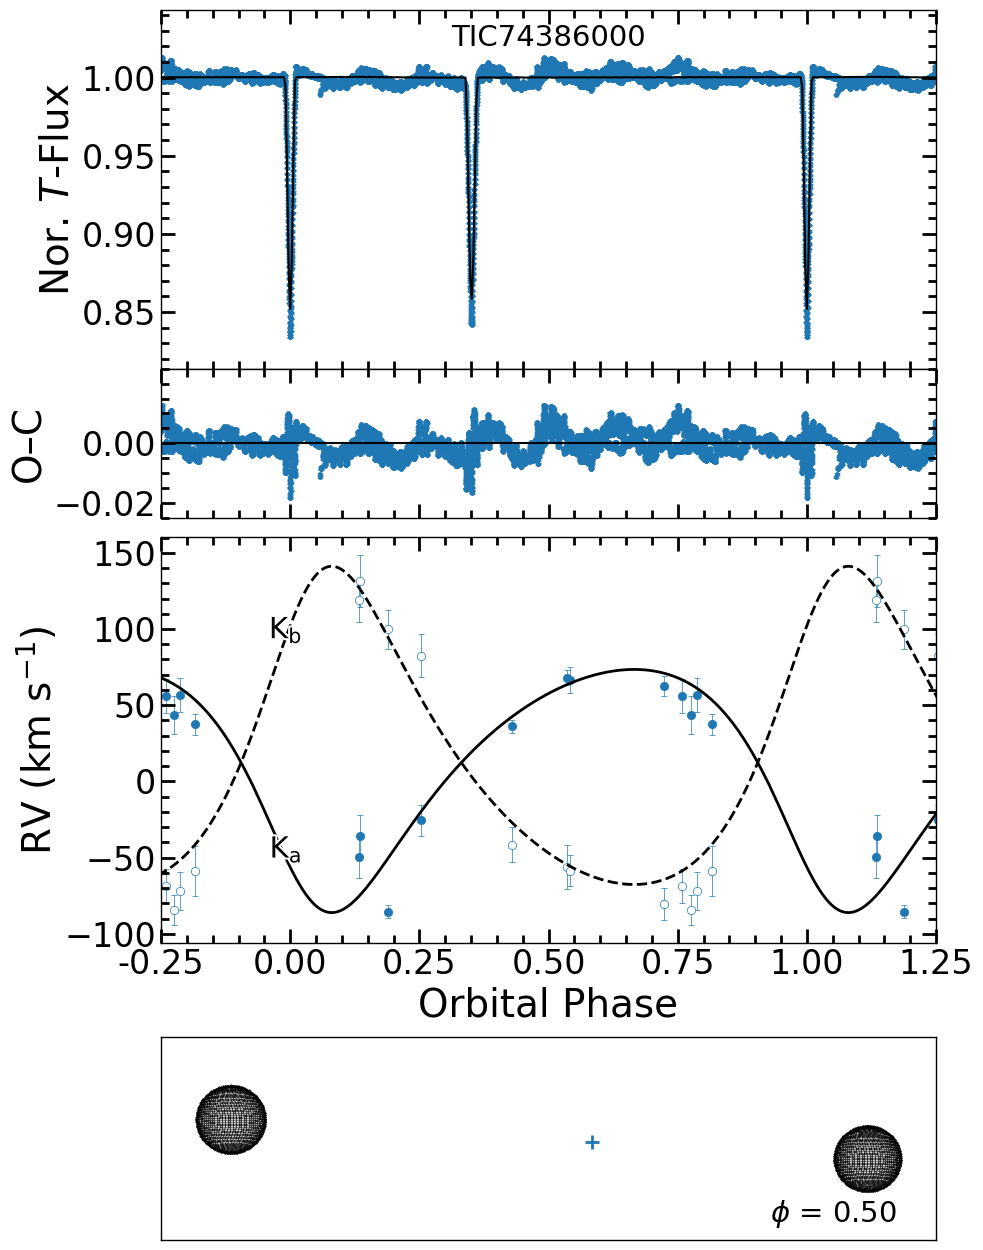

In [41]:
plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 1,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True
})

#===========================================================
# Figura e layout
fig = plt.figure(figsize=(10, 15))
gs = fig.add_gridspec(3, height_ratios=[1.0, 0.8, 0.4])

#===========================================================
# Painel 1 — Curva de luz (em cima) + O–C (embaixo)
bax = brokenaxes(
    ylims=((-0.025, 0.025), (np.min(y0)-0.02, np.max(y0)+0.03)),  # O–C embaixo
    xlims=[(-0.25, 1.25)],   # <-- aqui definimos o limite em fase
    hspace=0.0,
    d=0.0,
    height_ratios=[3, 1.25], # <-- controla a proporção (3:1)
    subplot_spec=gs[0]
)

# Curva de luz (painel de cima)
for shift in [-1, 0, 1]:
    bax.errorbar(np.array(phase0)+shift, y0, yerr=ey0, fmt="C0.", markersize=6, capsize=2,
                 elinewidth=0.5, ecolor='C0', markeredgecolor='C0', markeredgewidth=0.5, zorder=0)
bax.plot(phasex, emodel[1], 'k', linewidth=1.5, zorder=10)

# O–C (painel de baixo)
oc = y0 - emodel[0]
for shift in [-1, 0, 1]:
    bax.errorbar(np.array(phase0)+shift, oc, yerr=ey0, fmt="C0.", markersize=6, capsize=2,
                 elinewidth=0.5, ecolor='C0', markeredgecolor='C0', markeredgewidth=0.5, zorder=0)
bax.plot(phasex, np.zeros_like(phasex), 'k', linewidth=1.5, zorder=10)

# Formatação de eixos — mantém 4 bordas e remove apenas labels do eixo x
for ax in bax.axs:
    ax.minorticks_on()
    # Configura os major ticks
    ax.tick_params(axis='both', which='major', direction='in', top=True, right=True,
                length=10, width=2, labelsize=24)

    # Configura os minor ticks com comprimento diferente
    ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True,
                length=6, width=2)
    ax.tick_params(axis='x', which='both', labelbottom=False)

    # desenha bordas
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1)

# Labels
bax.axs[0].set_ylabel("Nor. $T$-Flux", fontsize=28)
# Adiciona texto indicando o objeto
bax.axs[0].text(0.5, 0.96, obj,
    transform=bax.axs[0].transAxes,
    fontsize=21, color='black',
    ha='center', va='top')

bax.axs[1].set_ylabel("O–C", fontsize=28)
bax.axs[1].set_yticks([-0.02, 0.00])

#===========================================================
# Painel 2 — Velocidades Radiais
ax2 = fig.add_subplot(gs[1], sharex=bax.axs[1])
ax2.minorticks_on()
# Configura os major ticks
ax2.tick_params(axis='both', which='major', direction='in', top=True, right=True,
                length=10, width=2, labelsize=24)

# Configura os minor ticks com comprimento diferente
ax2.tick_params(axis='both', which='minor', direction='in', top=True, right=True,
                length=6, width=2)
ax2.set_ylabel("RV (km s$^{-1}$)", fontsize=28)
ax2.set_xlabel("Orbital Phase", fontsize=28)
ax2.set_xlim(-0.25, 1.25)
ax2.set_xticks(np.arange(-0.25, 1.26, 0.25))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Dados das RVs
for shift in [-1, 0, 1]:
    # --- componente primária ---
    ax2.errorbar(x_rv1 + shift, y_rv1, yerr=ey_rv1,
                 fmt="C0.", markersize=12, capsize=2,
                 elinewidth=0.5, ecolor='C0',
                 markeredgecolor='C0', markeredgewidth=0.5,
                 zorder=0)
    
    # --- componente secundária ---
    ax2.errorbar(x_rv2 + shift, y_rv2, yerr=ey_rv2,
                 fmt="C0.", markersize=12, markerfacecolor='white', capsize=2,
                 elinewidth=0.5, ecolor='C0',
                 markeredgecolor='C0', markeredgewidth=0.5,
                 zorder=0)

# --- modelos RV ---
ax2.plot(phasex, emodel_rv1[0], 'k',   lw=2, label='K$_\\mathrm{a}$')
ax2.plot(phasex, emodel_rv2[0], 'k--', lw=2, label='K$_\\mathrm{b}$')

# índice central (apenas para referência)
mid_index = len(phasex) // 2 - 170

# --- texto sobre a curva da componente primária ---
text1 = ax2.annotate('K$_\mathrm{a}$',
             xy=(phasex[mid_index], emodel_rv1[0][mid_index]),   # <-- usa y_rv1
             fontsize=21,
             color='k',
             ha='center',
             #va='bottom',
             zorder=15)
text1.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='white'),
    path_effects.Normal()
])

# --- texto sobre a curva da componente secundária ---
text2 = ax2.annotate('K$_\mathrm{b}$',
             xy=(phasex[mid_index], emodel_rv2[0][mid_index]),   # <-- usa y_rv2
             fontsize=21,
             color='k',
             ha='center',
             #va='bottom',
             zorder=15)
text2.set_path_effects([
    path_effects.Stroke(linewidth=3, foreground='white'),
    path_effects.Normal()
])

#===========================================================
# Painel 3 — Modelo orbital
ax3 = fig.add_subplot(gs[2])
# Painel 3 — Remove completamente ticks e labels
ax3.tick_params(
    axis='both',       # x e y
    which='both',      # major e minor
    bottom=False, top=False, left=False, right=False,
    labelbottom=False, labelleft=False
)
sc = 0.06
ax3.set_ylim(min(model_3d[:,1])-sc, max(model_3d[:,1])+sc)

ax3.plot(model_3d[:,0], model_3d[:,1], '.k', ms=1)
ax3.plot(0, 0, '+C0', ms=10, markeredgewidth=2)

# Adiciona texto indicando a fase
ax3.text(0.95, 0.05, "$\phi$ = 0.50", transform=ax3.transAxes,
         fontsize=21, color='black', #fontweight='bold',
         ha='right', va='bottom') 

#===========================================================
plt.subplots_adjust(hspace=0.05)
# Reposiciona o painel 3 manualmente
box = ax3.get_position()
ax3.set_position([box.x0, box.y0 - 0.05, box.width, box.height])

# Salvar figura
for ext in ['jpg', 'pdf']:
    plt.savefig(f'4_curves_{obj}.{ext}', bbox_inches='tight', dpi=300)

plt.show()

In [42]:
#Save all results
#=======================================================
aux = np.column_stack([phasex, emodel[1]])
np.savetxt('model_{}.dat'.format(obj), aux)
aux = np.column_stack([x0, oc, ey0])
np.savetxt('oc_{}.dat'.format(obj), aux)
aux = np.column_stack([phasex, emodel_rv1[0]])
np.savetxt('rv1_model.dat', aux)
aux = np.column_stack([phasex, emodel_rv2[0]])
np.savetxt('rv2_model.dat', aux)

# Parâmetros Derivados

In [43]:
T2t = bparam[5][1]*10000
T1t = T1t*10000
T2_err1 = np.sqrt(T1t_err1**2 + (bparam[5][2]*10000)**2)
T2_err2 = np.sqrt(T1t_err2**2 + (bparam[5][3]*10000)**2)

bparam.append(['T1', T1t, T1t_err1, T1t_err2])
bparam.append(['T2', T2t, T2_err1, T2_err2])

# Inicializando listas
M1, M2 = [], []
R1, R2 = [], []
g1, g2 = [], []
L1, L2 = [], []

for i in range(len(stars[:])):
    M1.append(float(stars[i][1,1]))
    R1.append(float(stars[i][1,2]))
    g1.append(float(stars[i][1,4]))
    M2.append(float(stars[i][2,1]))
    R2.append(float(stars[i][2,2]))
    g2.append(float(stars[i][2,4]))
    L1.append(np.log10((4 * pi * 5.6697*10**(-8) * T1t**4 * (float(stars[i][1,2]) * R_Sun)**2) / L_Sun))
    L2.append(np.log10((4 * pi * 5.6697*10**(-8) * T2t**4 * (float(stars[i][2,2]) * R_Sun)**2) / L_Sun))

allparam = [M1, M2, R1, R2, g1, g2, L1, L2]

labels=["M1", "M2", "R1", "R2", "g1", "g2", "L1", "L2"]

for i in range(len(allparam)):
    mcmc = np.percentile(allparam[i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    bparam.append([labels[i], mcmc[1], q[0], q[1]])
    display(Math(txt))
np.savetxt('bparams.dat', bparam, fmt='%s')


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>